# 作業 2: 牛逼！情緒分析

資料集: [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015.pdf)

程式碼參考自: [huggingface](https://huggingface.co/)

> **資料集說明**

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

>**本次介紹模型為BERT**

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://github.com/google-research/bert)

程式碼參考自: [huggingface](https://huggingface.co/)

![](https://i.imgur.com/spiKPbQ.png)

[可搭配李宏毅大大的說明影片食用](https://youtu.be/UYPa347-DdE)

**訓練一個 BERT 分類模型，輸入是一句話，辨識出這句話的情緒傾向。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉。 **如  "HW2-BERT-112423050.ipynb"**

請 **隨意修改** 這個 colab 的程式來完成訓練 BERT 分類模型。**要跑得出來 Testing Accuracy, 須完成 TODO1-7**，不必一定要照著提示走。
繳交時記得改檔案標題的學號。

本次作業著重在學習 pytorch 的使用方法及 Transformer 家族中 BERT 的應用。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型可自行多嘗試不同組合，**不能只用已經 pretrained 好的模型**，一定再用新的資料訓練過
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存 output 結果 ，更改**檔名學號**，左上角 檔案 -> 下載成 ipynb 檔。
2. 交一個 pdf 檔，裡面需要附上**你的作業 colab 連結 ( 設為可編輯 )**、姓名學號年級 、過程和執行結果的截圖 ，並說明你程式撰寫的過程 、本次作業心得 ( 至少 50 字 )。
3. 文件內至少應貼上你的 Test Acc
4. 上述兩個檔案繳交至 ee-class。

> **算分標準**

* 基本分（90 分）：(Test_Acc - 60）(35 分) + Training function（20 分） + Model（15 分） + 文件（20 分）
  1. (Test_Acc - 60):  用訓練完的 bert-base-uncased 模型去看 Test 資料的 accuracy 再減去 60，最低此項目 0 分，最高此項目 35 分
  2. Training function : 完成前置準備所需的程式碼 ( 資料處理等 )，共 20 分 ( 包含 TODO1-4)
  3. Model : 完成模型建構 ，模型訓練及模型預測 ，共 15 分 (TODO5-7)
  4. 文件 : 共 20 分
    1.  姓名、學號、年級（1%）
    1.  colab 連結（1%）
    1. Test accuracy（2%）
    1. 撰寫過程與截圖（8%）
    1. 心得（8%，至少 50 字）
* 加分項（10 分 ）：請附上二種的 pretrained 模型結果（一個 5 分），最多只加到 10 分（ 即完成 2 個模型 ）
  1. 參考資料: [Transformer 模型總覽](https://huggingface.co/docs/transformers/index)
  2. 舉例：原本是 bert-base-uncased （完成這個就已經有 5 分了），如果你換其他模型如 distilbert-base-uncased ，再完成一次並記錄結果可以再加 5 分（ 可在文件中敘述不同模型的差異或建議 ）

有問題再來信助教: s112423023@g.ncu.edu.tw(蕭鈺宸)、112423050@g.ncu.edu.tw(郭柏成)


### 資料集下載

- 資料集說明 :
  - text: a string feature.
  - label: a classification label, with possible values including neg (0), pos (1).

### 請注意以下 ***TODO*** 區塊是需要改寫之處
* TODO
> ```
> ##########
> # todo #
> ##########
> ```

## 安裝與載入所需套件

In [ ]:
!pip install datasets transformers

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import torch
import torch.nn.functional as Fun
import transformers
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

## 一些模型會用到的小函數

* TODO1: 完成 get_pred()
> 從logits的dimension=1去取得結果中數值最高者當做預測結果
* TODO2: 完成 cal_metrics()
> 透過將 tensor 轉為 numpy，可使用 sklearn 的套件算出 acc, f1_score, recall 及 precision

In [ ]:
# 把輸入的矩陣變成一為向量
def get_pred(logits):
    return torch.argmax(logits, dim=1)

# calculate confusion metrics
def cal_metrics(pred, ans):
    # Convert tensors to numpy arrays
    pred = pred.cpu().detach().numpy()
    ans = ans.cpu().detach().numpy()
    # Calculate metrics
    accuracy = accuracy_score(ans, pred)
    f1 = f1_score(ans, pred, average='weighted')  # 'weighted' accounts for label imbalance
    recall = recall_score(ans, pred, average='weighted')
    precision = precision_score(ans, pred, average='weighted')

    return accuracy, f1, recall, precision

In [ ]:
# save model to path
def save_checkpoint(save_path, model):
  if save_path == None:
      return
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')

  model.load_state_dict(state_dict)
  return model

## 載入資料

- 這個資料集有分成 train, test, unsupervised

- 這次我們只使用 train 及 test 資料，且我們需要將原資料重新進行分割。

- 將兩份資料合併後切割成 3:1:1 或是 8:1:1 的 train/val/test 資料集。

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")

看一下資料格式長怎樣

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

* TODO3
  >把資料拿出來後 ，將 train 及 test 合併，重新切割後，儲存下來。

In [ ]:
import pandas as pd
all_data = [] # a list to save all data
for data in dataset['train']:
  all_data.append({'text':data['text'], 'label':data['label']})
for data in dataset['test']:
  all_data.append({'text':data['text'], 'label':data['label']})

all_df = pd.DataFrame(all_data, columns=['text', 'label'])
all_df.head(5)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


可以看一下兩個類別分布的比例

In [ ]:
all_df.label.value_counts() / len(all_df)

label
0    0.5
1    0.5
Name: count, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
# Split the combined dataset into training and a temp dataset (80% for training)
train_df, temp_data = train_test_split(all_df, random_state=1111, train_size=0.8)
# Further split the temp dataset into development and testing datasets evenly (50% each)
dev_df, test_df = train_test_split(temp_data, random_state=1111, train_size=0.5)
print('# of train_df:', len(train_df))
print('# of dev_df:', len(dev_df))
print('# of test_df data:', len(test_df))

# save data
train_df.to_csv('./train.tsv', sep='\t', index=False)
dev_df.to_csv('./val.tsv', sep='\t', index=False)
test_df.to_csv('./test.tsv', sep='\t', index=False)

# of train_df: 40000
# of dev_df: 5000
# of test_df data: 5000


### 自定義 Dataset，將 tokenzie 的步驟放進去

* TODO4: 完成 tokenize()
> 我們會需要拿到該句話的 input_ids、attenntion_mask 及 token_type_ids。

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch
import torch.nn.functional as Fun

# 使用PyTorch的Dataset來構建一個字定義資料加載器
class CustomDataset(Dataset):
  def __init__(self, mode, df, specify, args):
    assert mode in ["train", "val", "test"]  # 一般會切三份
    self.mode = mode
    self.df = df
    self.specify = specify # 指定用於預測的數據列名
    if self.mode != 'test':
      self.label = df['label'] #非測試模式需要標籤
    self.tokenizer = AutoTokenizer.from_pretrained(args["config"])
    self.max_len = args["max_len"]
    self.num_class = args["num_class"]

  def __len__(self):
    return len(self.df) #返回數據集的大小

  # 獲取單個數據樣本
  def __getitem__(self, index):

    sentence = str(self.df[self.specify][index])
    ids, mask = self.tokenize(sentence)


    if self.mode == "test":
            return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long)
    else:
        label = self.label[index]
        if self.num_class > 2:
            label = self.one_hot_label(label)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), torch.tensor(label, dtype=torch.long)

  # 若類別數超過2，將標籤轉換為one_hot編碼
  def one_hot_label(self, label):
    return Fun.one_hot(torch.tensor(label), num_classes = self.num_class)


  def tokenize(self,input_text):
  #使用 Bert tokenizer 對文本進行分詞和編碼
      encoded = self.tokenizer.encode_plus(
          input_text,                           # 輸入文本
          add_special_tokens=True,              #添加特殊符號如CLS
          max_length=self.max_len,              # 設定最大長度，超過會被截斷
          pad_to_max_length=True,               # 填充到最大長度
          return_attention_mask=True,
          return_tensors='pt',                  # 返回 PyTorch tensors
          truncation=True,                      # 截斷文本以符合最大長度
      )

      return encoded['input_ids'][0], encoded['attention_mask'][0]


## 建立模型

*   自己重新寫分類模型 (不可直接抄襲參考來源) ([參考來源](https://github.com/huggingface/transformers/blob/v4.39.1/src/transformers/models/bert/modeling_bert.py#L1519))
*   模型訓練與評估的程式碼大致上相同，差別在於「模型是否繼續進行梯度下降」，以及「模型參數是否繼續訓練」



* TODO5: 完成 BertClassifier
> - 在初始化的地方加上dropout, linear layer（等於一層NN），其維度為類別數量；
> - 在forward function中把輸入值放進對應層數（bert -> dropout -> classifier）；
    
    > 請注意我們只取用 bert 輸出的 sentence representation 去做分類

In [ ]:
import torch.nn as nn
from transformers import DistilBertModel, DistilBertPreTrainedModel, DistilBertConfig
# BERT Model
class DistilBertClassifier(DistilBertPreTrainedModel):
  def __init__(self, config, args):
    super(DistilBertClassifier, self).__init__(config)
    self.distilbert = DistilBertModel(config)                                     #初始化 BERT Model
    self.num_labels = args["num_class"]                               #類別數量
    self.dropout = nn.Dropout(args.get("dropout",0.7))                #dropout層，減少過擬合
    self.classifier = nn.Linear(config.dim, self.num_labels)  #初始化一個線性層，用於從 BERT 的輸出到最終的類別預測
    self.init_weights()                                              #初始化模型權重


  def forward(self, input_ids=None, attention_mask=None):
        # bert output
      outputs = self.distilbert(
            input_ids = input_ids,
            attention_mask=attention_mask,
        )

      # 從輸出中獲取 [CLS] 標記的輸出，用於分類的任務
      hidden_state = outputs[0]
      pooled_output = hidden_state[:, 0]
      pooled_output = self.dropout(pooled_output) #在經過線性層之前應用 Dropout
      logits = self.classifier(pooled_output) #通過線性層得到最終的 logits

      return logits

這是已經寫好的evaluate()，train()會跟他很像

(# 在評估模型的時候，不需要梯度下降)

In [ ]:
# evaluate dataloader
def evaluate(model, data_loader, device):
  val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  loss_fct = torch.nn.CrossEntropyLoss()
  model.eval()
  with torch.no_grad():
    loop = tqdm((data_loader), total=len(data_loader), leave=True, colour='blue')
    for data in loop:
      ids, masks, labels = [t.to(device) for t in (data[0], data[1], data[2])]

      logits = model(input_ids = ids,
              attention_mask = masks)
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
      loss = loss_fct(logits, labels)

      val_loss += loss.item()
      val_acc += acc
      val_f1 += f1
      val_rec += rec
      val_prec += prec
      step_count+=1

    val_loss = val_loss / step_count
    val_acc = val_acc / step_count
    val_f1 = val_f1 / step_count
    val_rec = val_rec / step_count
    val_prec = val_prec / step_count

  return val_loss, val_acc, val_f1, val_rec, val_prec

## 開始訓練

### 定義你的 Hyperparameters

* 如果電腦的記憶體不夠可以試著減少 batch_size
* 因為我們採用現有的模型去 fine-tune，所以一般不需要設太多 epochs
* config 就是我們所使用的現有模型，可以自己找適合的做替換
* 這份 work 是做二分類，所以 num_class 為 2
* 如果你的模型 overfit 了，可以把 dropout 調高
* 可以試著調高或調低 learning_rate，這會影響他的學習速度（跨步的大小）
* 你應該先檢閱你的資料再來決定 max_len （但 BERT 最大只吃到 512）

In [ ]:
from datetime import datetime
parameters = {
    "num_class": 2,
    "time": str(datetime.now()).replace(" ", "_"),
    # Hyperparameters
    "model_name": 'distilbert-base-uncased',
    "config": 'distilbert-base-uncased',
    "learning_rate": 0.000082,
    "epochs": 3,
    "max_len": 512,
    "batch_size": 16,
    "dropout": 0.7,
}

### 載入資料

- 讀入資料並傳入自訂的 Dataset 以自訂資料格式

- 之後傳入 DataLoader 以利後續訓練進行（將資料批次化以免記憶體爆掉 ）

    (# 你可以決定要 sample 部分資料還是全部都丟進去)

In [ ]:
import transformers
import pandas as pd

# load training data
train_df = pd.read_csv('./train.tsv', sep = '\t').sample(4000).reset_index(drop=True)
train_dataset = CustomDataset('train', train_df, 'text', parameters)
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)

# load validation data
val_df = pd.read_csv('./val.tsv', sep = '\t').sample(500).reset_index(drop=True)
val_dataset = CustomDataset('val', val_df, 'text', parameters)
val_loader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=True)

### 初始化模型
*   載入模型（這邊會使用已經訓練過的模型，Fine-tune 我們的資料集）
*   定義 Optimization
  *   通常用 Adam 就可以了，你也可以換SGD之類的試看看
  *   可以自己看需不需要加 scheduler（可以自己寫一個 function，也可以直接套用現有的function）
  
  ［請記得 pytorch 中是以 step 去計算，想要用 epoch 去訂定需自行換算 ］




In [ ]:
transformers.logging.set_verbosity_error() # 關閉警告消息

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 從預訓練的 BERT 模型加載自定義的分類器，並將其移動到指定的設備（GPU或CPU）
model = DistilBertClassifier.from_pretrained(parameters['config'], parameters).to(device)
loss_fct = torch.nn.CrossEntropyLoss() # 使用 cross entrophy loss
# 定義優化器，這裡使用 Adam 優化演算法
# 設置學習率，以及 beta 和 epsilon 參數（這些參數控制優化器的行為）
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.98), eps=1e-9)
# 計算總的訓練步數，為訓練輪數乘以訓練數據加載器中的批次數量
total_steps = len(train_loader) * parameters["epochs"]
# 設定帶預熱的線性學習率調度器
# 預熱步驟通常是訓練開始的一部分，在這期間學習率逐漸增加到初始設置的學習率
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(total_steps * 0.1),
                                            num_training_steps=total_steps)

* 因為是做分類任務，所以這裡用 CrossEntrophyLoss
* 由於在 pytorch 中，CrossEntrophyLoss 吃的 input 是未經 softmax 的值，所以在模型中不必加入 softmax
* 但若在後期想取得各類別實際機率就要經過 softmax 轉換
* logits 的數值不等於機率 ！！但一般而言，logits 中較大者會與經過 softmax 轉換後的結果一致

* TODO6: 完成訓練
   >可參照 evaluate() 並稍作調整以完成訓練

In [ ]:
import time

# 初始化存儲訓練和驗證階段性能指標的字典
metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
mode = ['train_', 'val_']
record = {s+m :[] for s in mode for m in metrics}

# 開始訓練過程
for epoch in range(parameters["epochs"]):

    st_time = time.time()
    train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0

    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{parameters['epochs']}"):
        ids, masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()  # 清除之前的梯度

        logits = model(input_ids=ids, attention_mask=masks)

        loss = loss_fct(logits.view(-1, parameters['num_class']), labels.view(-1))
        loss.backward()           # 反向傳播計算梯度
        optimizer.step()          # 更新模型參數
        scheduler.step()          # 更新學習率
        preds = get_pred(logits)  # 獲取預測結果

        # 累加損失和計算準確率、F1分數、召回率、精確率
        train_loss += loss.item()
        acc, f1, rec, prec = cal_metrics(preds, labels)
        train_acc += acc
        train_f1 += f1
        train_rec += rec
        train_prec += prec
        step_count += 1


    # 每個epoch結束後在驗證集上評估模型性能
    val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, val_loader, device)
    # 計算平均損失和性能指標
    train_loss = train_loss / step_count
    train_acc = train_acc / step_count
    train_f1 = train_f1 / step_count
    train_rec = train_rec / step_count
    train_prec = train_prec / step_count

    print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
    print('         loss     acc     f1      rec    prec')
    print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
    print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

     # 紀錄每個訓練epoch的性能指標
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['train_f1'].append(train_f1)
    record['train_rec'].append(train_rec)
    record['train_prec'].append(train_prec)

    record['val_loss'].append(val_loss)
    record['val_acc'].append(val_acc)
    record['val_f1'].append(val_f1)
    record['val_rec'].append(val_rec)
    record['val_prec'].append(val_prec)

100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


[epoch 1] cost time: 212.3127 s
         loss     acc     f1      rec    prec
train | 0.4413, 0.7802, 0.7711, 0.7802, 0.8137
val  | 0.2732, 0.8984, 0.8979, 0.8984, 0.9100



100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


[epoch 2] cost time: 206.7476 s
         loss     acc     f1      rec    prec
train | 0.1652, 0.9360, 0.9356, 0.9360, 0.9446
val  | 0.2356, 0.9004, 0.9010, 0.9004, 0.9158



100%|██████████| 32/32 [00:09<00:00,  3.39it/s]

[epoch 3] cost time: 206.9287 s
         loss     acc     f1      rec    prec
train | 0.0350, 0.9892, 0.9893, 0.9892, 0.9908
val  | 0.3120, 0.9121, 0.9124, 0.9121, 0.9238



In [ ]:
# save model
save_checkpoint('./bert.pt' , model)

Model saved to ==> ./bert.pt


### 畫圖

In [ ]:
# 畫出learning curve
import matplotlib.pyplot as plt
def draw_pics(record, name, img_save=False, show=False):
    x_ticks = range(1, parameters["epochs"]+1)

    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue',
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink',
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)

    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')

    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()

    plt.close()

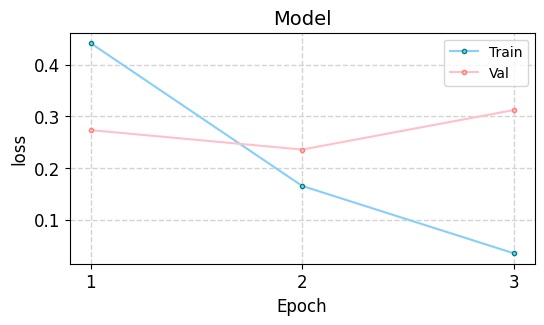

In [ ]:
draw_pics(record, 'loss', img_save=False, show=True)

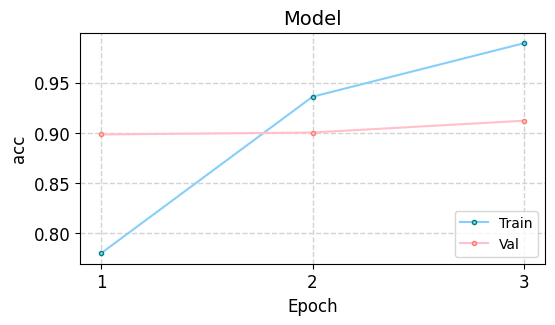

In [ ]:
draw_pics(record, 'acc', img_save=False, show=True)

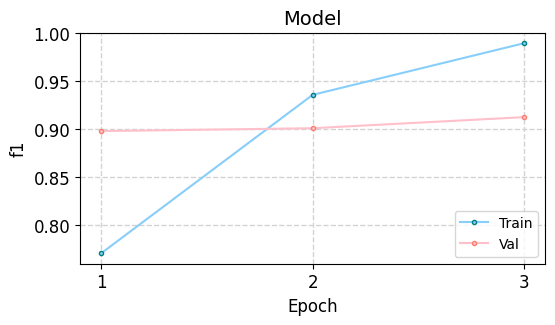

In [ ]:
draw_pics(record, 'f1', img_save=False, show=True)

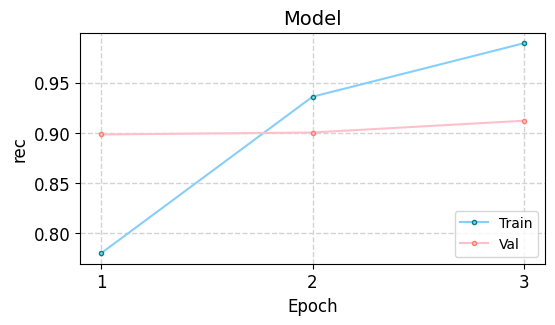

In [ ]:
draw_pics(record, 'rec', img_save=False, show=True)

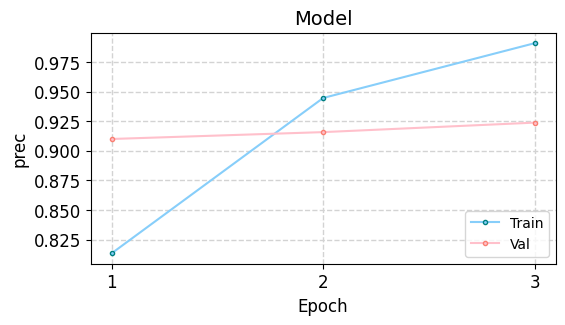

In [ ]:
draw_pics(record, 'prec', img_save=False, show=True)

## 預測結果

預測單筆（跟評估的程式大同小異）




In [ ]:
def Softmax(x):
    """
    計算給定輸入張量 x 的Softmax。
    Softmax 函數用於多類別分類的輸出層，將 logits（原始輸出）轉換為概率分佈。

    參數:
    - x: 一個張量，通常是未經歸一化的預測值或logits。

    返回:
    - 一個張量，表示 x 中每個元素的Softmax概率值。
    """
    return torch.exp(x- torch.max(x)) / torch.exp(x- torch.max(x)).sum()

def label2class(label):
    """
    將數字標籤轉換為對應的類別名稱。
    這在將模型的預測輸出（通常是數字標籤）轉換為更易於理解的形式時非常有用。

    參數:
    - label: 數字標籤 (整數)，在這個函數中，0 被映射到 'negative'，1 被映射到 'positive'。

    返回:
    - 字符串，表示標籤對應的類別名稱。
    """
    l2c = {0:'negative', 1:'positive'}
    return l2c[label]

* TODO7: 完成 predict_one()

In [ ]:
# 對單一句子進行預測，返回每個類別的概率及預測的類別
def predict_one(query, model):

    # 載入tokenizer
    tokenizer = AutoTokenizer.from_pretrained(parameters['config'])

    # 將文本tokenize
    inputs = tokenizer(query, return_tensors="pt", max_length=parameters['max_len'], truncation=True, padding="max_length")
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # 將數據移動到模型所在設備
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # 使用模型進行預測
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

    # 將logits轉成softmax
    probs = Fun.softmax(logits, dim=1)

    # 最大值的索引即是類別
    _, pred = torch.max(probs, dim=1)
    return probs, pred


In [ ]:
# you can load model from existing result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 建立一個初始化模型，採用預訓練模型
init_model = DistilBertClassifier.from_pretrained(parameters['config'], parameters)
# 從指定文件加載模型權重，然後將模型移至指定的裝置
model = load_checkpoint('./bert.pt', init_model, device).to(device)

Model loaded from <== ./bert.pt


In [ ]:
%%time
probs, pred = predict_one("This movie doesn't attract me", model)
#print(label2class(pred))
print(f"Predicted class: {label2class(pred.item())}, Probabilities: {probs.cpu().numpy()}")

Predicted class: negative, Probabilities: [[9.9935263e-01 6.4732757e-04]]
CPU times: user 83.6 ms, sys: 2.97 ms, total: 86.5 ms
Wall time: 184 ms


你也可以像 evaluate function一樣，把它寫成 dataloader 的形式

In [ ]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_probs, total_pred = [], []
  loop = tqdm((data_loader), total=len(data_loader), leave=True, colour='green')

  model.eval()
  with torch.no_grad():
    for data in loop:
      # 將輸入數據移到設定的裝置上
      input_ids, attention_mask = [t.to(device) for t in data]

      # 前向傳播得到logits
      logits = model(input_ids, attention_mask)
      # 使用Softmax函數計算概率
      probs = Fun.softmax(logits, dim=1)  # 獲取每個類別的概率
      pred = torch.argmax(probs, dim=1).item()

      total_probs.append(probs.cpu().numpy())
      total_pred.append(pred)

  return total_probs, total_pred

In [ ]:
# 加載測試數據集
test_df = pd.read_csv('./test.tsv', sep = '\t')
test_dataset = CustomDataset('test', test_df, 'text', parameters)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

total_probs, total_pred = predict(test_loader, model)
res = test_df.copy()
# 在原始數據文件中新增一列 'pred'，用於存儲預測的類別
res['pred'] = total_pred

# 將帶有預測結果的數據保存到新的 TSV 文件中
res.to_csv('./result.tsv', sep='\t', index=False)

100%|██████████| 5000/5000 [01:39<00:00, 50.12it/s]


In [ ]:
res.head(5)

,text,label,pred
0,This obviously was a pretty low budget product...,0,0
1,My girls 4 and 6 love this show. We stumbled a...,1,1
2,"After watching a dozen episodes, I decided to ...",0,0
3,One of the BEST movies I have seen in a very l...,1,1
4,The year 2000 had been a bad year for indian f...,1,1


In [ ]:
# 計算測試集的準確率，並印出結果
correct = 0
for idx, pred in enumerate(res['pred']):
  if pred == res['label'][idx]:
    correct += 1
print('test accuracy = %.4f'%(correct/len(test_df)))

test accuracy = 0.8964
